# CURVE AB

This notebook is set up for data analysis and research.



```
P(s) = (X, Y, Z) = (
    L_A * s,          # X轴：线性化的A曲线长度
    x_B(t(s)),        # Y轴：B曲线x坐标
    y_B(t(s))         # Z轴：B曲线y坐标
)
```

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from svg.path import parse_path
from svg.path.path import Line, CubicBezier

# INPUT

# 输入曲线数据
A_d = "M14 57.0001C29.3464 35.0113 51.5 22 85 22C110 22 134 25 160.5 52.5"
B_d = "M0.5 65.5C28.9136 9.86327 64 -3.92666 102 1.99999C140 7.92664 170 29.5 181 40"

def parse_svg_path(d):
    """解析SVG路径为贝塞尔曲线段
    
    Args:
        d (str): SVG路径字符串
    
    Returns:
        list: 包含曲线段信息的字典列表
    """
    path = parse_path(d)
    segments = []
    for e in path:
        if isinstance(e, CubicBezier):
            segments.append({
                'start': (e.start.real, e.start.imag),
                'c1': (e.control1.real, e.control1.imag),
                'c2': (e.control2.real, e.control2.imag),
                'end': (e.end.real, e.end.imag)
            })
        elif isinstance(e, Line):
            segments.append({
                'start': (e.start.real, e.start.imag),
                'end': (e.end.real, e.end.imag)
            })
    return segments


def bezier_sample(segments, n_samples=50):
    """采样贝塞尔曲线
    
    Args:
        segments (list): 曲线段列表
        n_samples (int): 每段曲线的采样点数
    
    Returns:
        np.array: 采样点数组，形状为 (n_points, 2)
    """
    points = []
    for seg in segments:
        if 'c1' in seg:  # 三次贝塞尔曲线
            t = np.linspace(0, 1, n_samples)
            x = (1-t)**3*seg['start'][0] + 3*(1-t)**2*t*seg['c1'][0] + 3*(1-t)*t**2*seg['c2'][0] + t**3*seg['end'][0]
            y = (1-t)**3*seg['start'][1] + 3*(1-t)**2*t*seg['c1'][1] + 3*(1-t)*t**2*seg['c2'][1] + t**3*seg['end'][1]
            points.extend(list(zip(x, y)))
        else:  # 直线段
            x = np.linspace(seg['start'][0], seg['end'][0], n_samples)
            y = np.linspace(seg['start'][1], seg['end'][1], n_samples)
            points.extend(list(zip(x, y)))
    return np.array(points)

In [34]:
def plot_bezier_curves(A_points, B_points, A_segments, B_segments):
    """绘制贝塞尔曲线及其控制点
    
    Args:
        A_points (np.array): A曲线的采样点
        B_points (np.array): B曲线的采样点
        A_segments (list): A曲线的段信息
        B_segments (list): B曲线的段信息
    """
    plt.figure(figsize=(12, 8))
    
    # 绘制曲线和采样点
    plt.plot(A_points[:, 0], -A_points[:, 1], 'b-', label='Curve A', linewidth=1, alpha=0.5)
    plt.scatter(A_points[:, 0], -A_points[:, 1], c='blue', s=20, alpha=0.5, label='A Points')
    
    plt.plot(B_points[:, 0], -B_points[:, 1], 'r-', label='Curve B', linewidth=1, alpha=0.5)
    plt.scatter(B_points[:, 0], -B_points[:, 1], c='red', s=20, alpha=0.5, label='B Points')
    
    # 绘制控制点
    for seg in A_segments:
        if 'c1' in seg:
            plt.plot(seg['start'][0], -seg['start'][1], 'bo', markersize=10, alpha=0.7)
            plt.plot(seg['c1'][0], -seg['c1'][1], 'bx', markersize=10, alpha=0.7)
            plt.plot(seg['c2'][0], -seg['c2'][1], 'bx', markersize=10, alpha=0.7)
            plt.plot(seg['end'][0], -seg['end'][1], 'bo', markersize=10, alpha=0.7)
    
    for seg in B_segments:
        if 'c1' in seg:
            plt.plot(seg['start'][0], -seg['start'][1], 'ro', markersize=10, alpha=0.7)
            plt.plot(seg['c1'][0], -seg['c1'][1], 'rx', markersize=10, alpha=0.7)
            plt.plot(seg['c2'][0], -seg['c2'][1], 'rx', markersize=10, alpha=0.7)
            plt.plot(seg['end'][0], -seg['end'][1], 'ro', markersize=10, alpha=0.7)
    
    plt.grid(True)
    plt.legend()
    plt.title('Bezier Curves with Sampling Points')
    plt.axis('equal')
    plt.xlim(-10, 190)
    plt.ylim(-70, 10)
    plt.show()

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


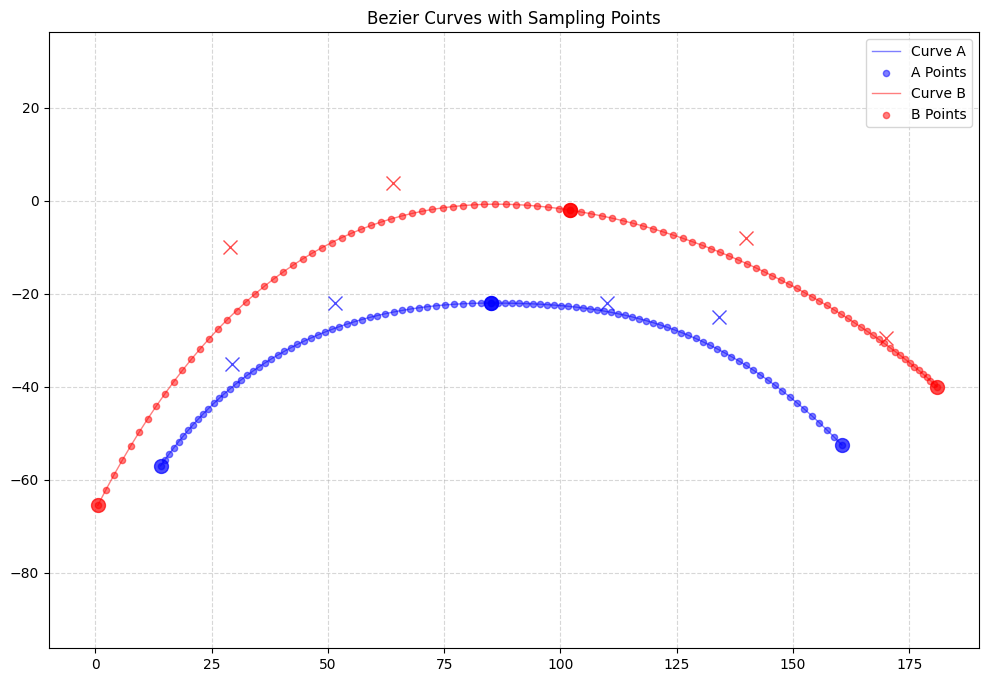

In [35]:
# 解析SVG路径
A_segments = parse_svg_path(A_d)
B_segments = parse_svg_path(B_d)

# 采样曲线
A_points = bezier_sample(A_segments, n_samples=50)
B_points = bezier_sample(B_segments, n_samples=50)

# 绘制曲线
plot_bezier_curves(A_points, B_points, A_segments, B_segments)

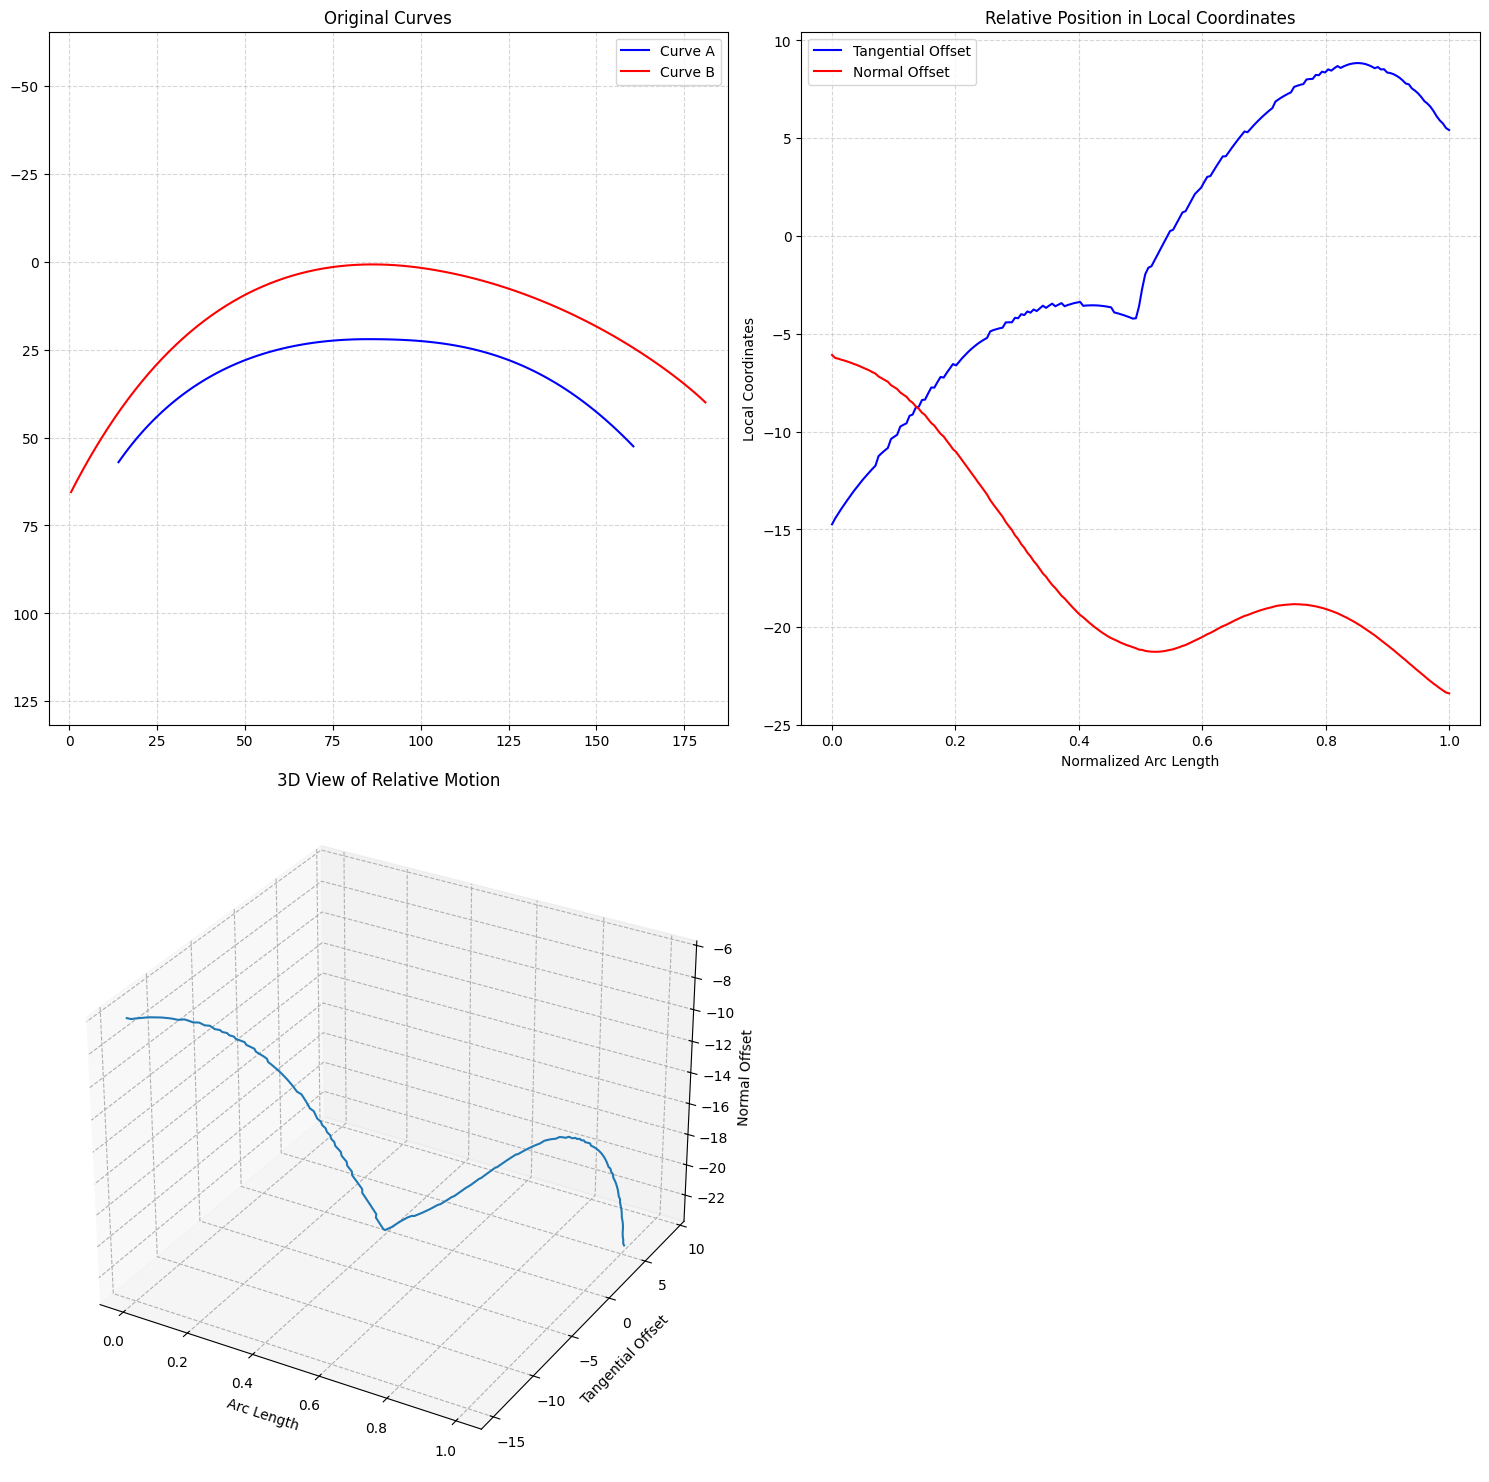

In [36]:
import numpy as np
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def arc_length_parameterization(points):
    """弧长参数化"""
    dx = np.diff(points[:,0])
    dy = np.diff(points[:,1])
    seg_lengths = np.sqrt(dx**2 + dy**2)
    cum_length = np.cumsum(seg_lengths)
    total_length = cum_length[-1]
    normalized = np.insert(cum_length, 0, 0) / total_length
    return normalized, total_length

def compute_tangent_normal(points):
    """计算曲线的切向量和法向量"""
    # 计算切向量
    dx = np.gradient(points[:,0])
    dy = np.gradient(points[:,1])
    
    # 归一化切向量
    lengths = np.sqrt(dx**2 + dy**2)
    tangent = np.column_stack([dx/lengths, dy/lengths])
    
    # 计算法向量 (切向量逆时针旋转90度)
    normal = np.column_stack([-tangent[:,1], tangent[:,0]])
    
    return tangent, normal

def transform_to_local_coordinates(point, origin, tangent, normal):
    """将点转换到局部坐标系"""
    # 将点平移到原点
    translated = point - origin
    
    # 投影到切向和法向方向
    x_local = np.dot(translated, tangent)
    y_local = np.dot(translated, normal)
    
    return np.array([x_local, y_local])

# 假设 A_points 和 B_points 已经定义

# 计算曲线A的弧长参数化和局部坐标系
s_A, L_A = arc_length_parameterization(A_points)
tangent_A, normal_A = compute_tangent_normal(A_points)

# 为曲线B创建更密集的采样点
num_samples = 1000
t_dense = np.linspace(0, 1, num_samples)
B_dense = np.column_stack([
    np.interp(t_dense, np.linspace(0, 1, len(B_points)), B_points[:,0]),
    np.interp(t_dense, np.linspace(0, 1, len(B_points)), B_points[:,1])
])

# 计算密集采样点的弧长参数化
s_B_dense, _ = arc_length_parameterization(B_dense)

# 对曲线A选择采样点
num_A_samples = 200
s_values = np.linspace(0, 1, num_A_samples)
A_sampled = np.column_stack([
    np.interp(s_values, np.linspace(0, 1, len(A_points)), A_points[:,0]),
    np.interp(s_values, np.linspace(0, 1, len(A_points)), A_points[:,1])
])

# 计算采样点的切向量和法向量
tangent_sampled, normal_sampled = compute_tangent_normal(A_sampled)

# 对每个曲线A的采样点，找到对应的曲线B点并转换到局部坐标系
local_coordinates = []
for i in range(len(s_values)):
    # 找到对应的曲线B点
    idx = np.argmin(np.abs(s_B_dense - s_values[i]))
    B_point = B_dense[idx]
    
    # 转换到局部坐标系
    local_coord = transform_to_local_coordinates(
        B_point, 
        A_sampled[i], 
        tangent_sampled[i], 
        normal_sampled[i]
    )
    local_coordinates.append(local_coord)

local_coordinates = np.array(local_coordinates)

# 绘制结果
fig = plt.figure(figsize=(15, 15))

# 原始曲线
ax1 = fig.add_subplot(221)
ax1.plot(A_points[:,0], A_points[:,1], 'b-', label='Curve A')
ax1.plot(B_points[:,0], B_points[:,1], 'r-', label='Curve B')
ax1.set_title('Original Curves')
ax1.grid(True)
ax1.legend()
ax1.axis('equal')
ax1.invert_yaxis()

# 相对关系图
ax2 = fig.add_subplot(222)
ax2.plot(s_values, local_coordinates[:,0], 'b-', label='Tangential Offset')
ax2.plot(s_values, local_coordinates[:,1], 'r-', label='Normal Offset')
ax2.set_xlabel('Normalized Arc Length')
ax2.set_ylabel('Local Coordinates')
ax2.set_title('Relative Position in Local Coordinates')
ax2.grid(True)
ax2.legend()

# 3D视图
ax3 = fig.add_subplot(223, projection='3d')
ax3.plot(s_values, local_coordinates[:,0], local_coordinates[:,1])
ax3.set_xlabel('Arc Length')
ax3.set_ylabel('Tangential Offset')
ax3.set_zlabel('Normal Offset')
ax3.set_title('3D View of Relative Motion')

plt.tight_layout()
plt.show()

# 曲线相对位置分析说明

## 视图说明

这段代码生成了三个视图，用于分析两条曲线（曲线A和曲线B）之间的相对位置关系：

### 1. 原始曲线视图（左上）

- 显示两条曲线在原始坐标系中的形状
- 蓝色线表示曲线A
- 红色线表示曲线B
- 这个视图帮助我们直观理解两条曲线的空间关系

### 2. 相对关系图（右上）

- X轴：表示曲线A的标准化弧长参数（0到1）
- 蓝线：表示切向偏移量（前后方向的距离）
- 红线：表示法向偏移量（左右方向的距离）
- 这个视图帮助我们理解在曲线A的每个位置，曲线B相对于它的偏移情况

### 3. 3D相对运动视图（左下）

- X轴：曲线A的标准化弧长参数（0到1）
- Y轴：切向偏移量（表示曲线B相对于曲线A的前后位置）
  - 正值：B在A的前方
  - 负值：B在A的后方
- Z轴：法向偏移量（表示曲线B相对于曲线A的左右位置）
  - 正值：B在A的左侧
  - 负值：B在A的右侧

这个3D视图将两个偏移量组合在一起，形成了一条空间曲线，帮助我们理解：
1. 曲线B如何随着曲线A的推进而变化位置
2. 两条曲线之间的相对运动关系
3. 在曲线A的每个位置，曲线B的相对偏移状态

## 应用场景

这种分析方法在以下场景特别有用：
- 机器人路径规划中的跟随行为分析
- 两个物体之间的相对运动分析
- 舞蹈编排中的双人动作设计
- 工业自动化中的协同运动控制


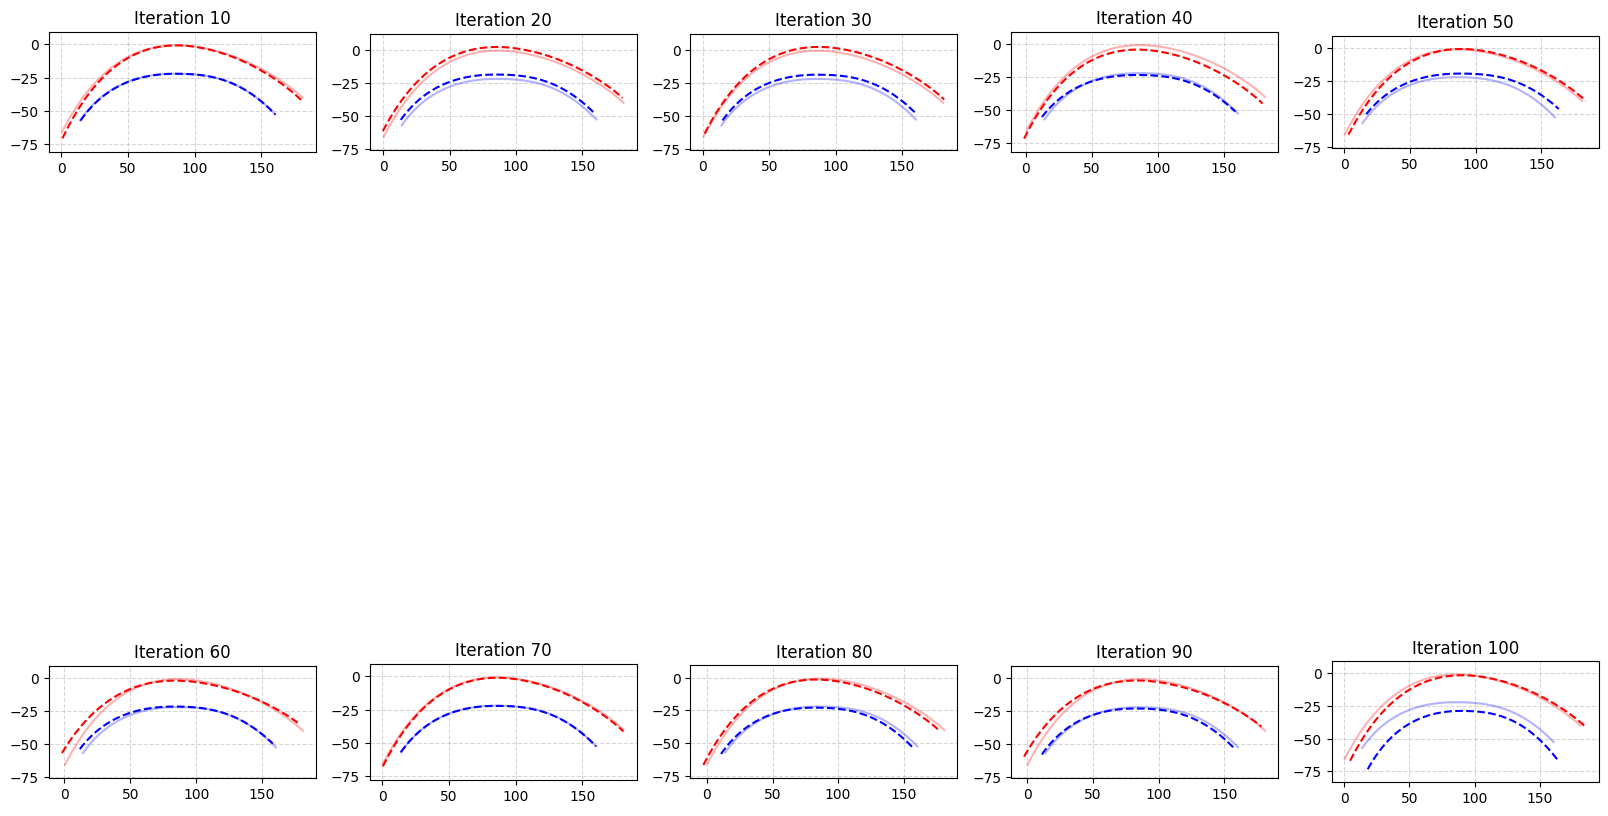

<Figure size 2000x1000 with 0 Axes>

噪声统计信息：
A曲线平均噪声幅度: 3.8758 像素
B曲线平均噪声幅度: 3.3473 像素
警告：第49个点的切向量接近零
警告：第49个点的切向量接近零
警告：第49个点的切向量接近零
警告：第49个点的切向量接近零
警告：第49个点的切向量接近零
警告：第49个点的切向量接近零
警告：第49个点的切向量接近零
警告：第49个点的切向量接近零
警告：第49个点的切向量接近零
警告：第49个点的切向量接近零
警告：第49个点的切向量接近零
警告：第49个点的切向量接近零
警告：第49个点的切向量接近零
警告：第49个点的切向量接近零
警告：第49个点的切向量接近零
警告：第49个点的切向量接近零
警告：第49个点的切向量接近零
警告：第49个点的切向量接近零
警告：第49个点的切向量接近零
警告：第49个点的切向量接近零
警告：第49个点的切向量接近零
警告：第49个点的切向量接近零
警告：第49个点的切向量接近零
警告：第49个点的切向量接近零
警告：第49个点的切向量接近零
警告：第49个点的切向量接近零
警告：第49个点的切向量接近零
警告：第49个点的切向量接近零
警告：第49个点的切向量接近零
警告：第49个点的切向量接近零
警告：第49个点的切向量接近零
警告：第49个点的切向量接近零
警告：第49个点的切向量接近零
警告：第49个点的切向量接近零
警告：第49个点的切向量接近零
警告：第49个点的切向量接近零
警告：第49个点的切向量接近零
警告：第49个点的切向量接近零
警告：第49个点的切向量接近零
警告：第49个点的切向量接近零
警告：第49个点的切向量接近零
警告：第49个点的切向量接近零
警告：第49个点的切向量接近零
警告：第49个点的切向量接近零
警告：第49个点的切向量接近零
警告：第49个点的切向量接近零
警告：第49个点的切向量接近零
警告：第49个点的切向量接近零
警告：第49个点的切向量接近零
警告：第49个点的切向量接近零
警告：第49个点的切向量接近零
警告：第49个点的切向量接近零
警告：第49个点的切向量接近零
警告：第49个点的切向量接近零
警告：第49个点的切向量接近零
警告：第49个点的切向量接近零
警告：第49个点的切向量接近零
警告：第49个点的切向量接近零
警告：第49个点的切向量接近零
警告：第49

/Users/remi/mycode/kigland-research-curve-ab/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.5042 - mae: 0.5403 - val_loss: 0.2623 - val_mae: 0.3586
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step - loss: 0.2447 - mae: 0.3383 - val_loss: 0.2521 - val_mae: 0.3410
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step - loss: 0.2489 - mae: 0.3401 - val_loss: 0.2530 - val_mae: 0.3431
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 856us/step - loss: 0.2510 - mae: 0.3448 - val_loss: 0.2506 - val_mae: 0.3411
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step - loss: 0.2374 - mae: 0.3316 - val_loss: 0.2605 - val_mae: 0.3460
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 813us/step - loss: 0.2459 - mae: 0.3401 - val_loss: 0.2651 - val_mae: 0.3509
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step - loss: 0.2439 - mae: 0.3388 - val_loss: 0.2478 - val_mae: 0.3358
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 822us/step - loss: 0.2438 - mae: 0.3340 - val_loss: 0.2540 - val_mae: 0.3407
Epoch 9/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step

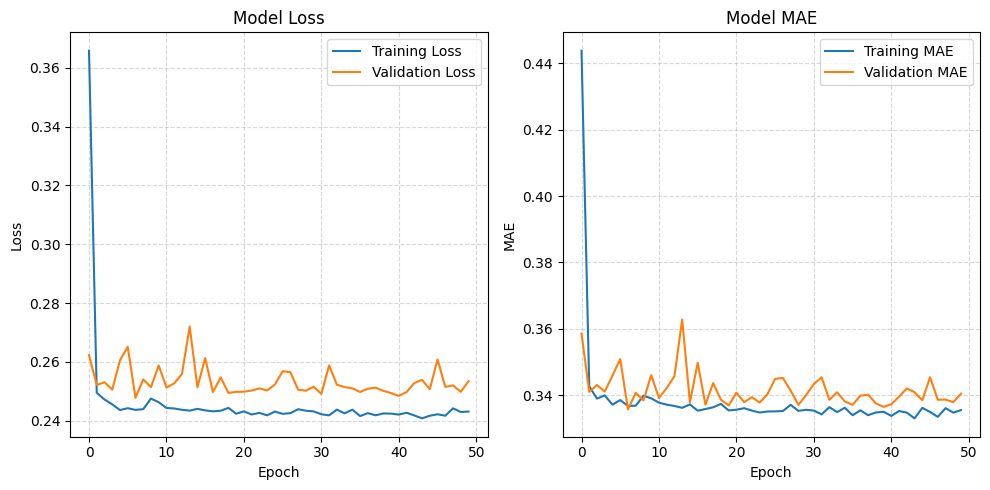

A_params范围: 0.0 1.0
X_scaled范围: -1.6973317055007067 1.8090857284883435
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
预测值范围: -3.1827378 2.2415183
反标准化后范围: -23.440575 25.30584
警告：预测时第49个点的切向量接近零


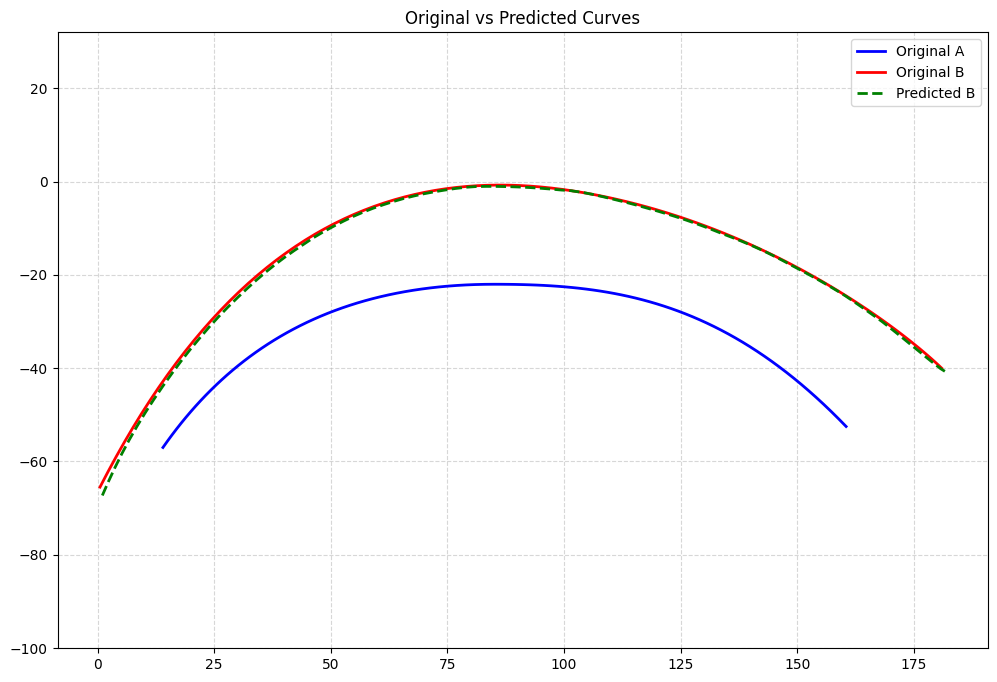

平均预测误差: 0.7579 像素


In [37]:
# 导入必要的包
import numpy as np
import matplotlib.pyplot as plt
from train_model import train_curve_model, predict_B_curve

# 使用示例 SVG 数据
A_d = "M14 57.0001C29.3464 35.0113 51.5 22 85 22C110 22 134 25 160.5 52.5"
B_d = "M0.5 65.5C28.9136 9.86327 64 -3.92666 102 1.99999C140 7.92664 170 29.5 181 40"

# 获取曲线点
A_segments = parse_svg_path(A_d)
B_segments = parse_svg_path(B_d)

A_points = bezier_sample(A_segments)
B_points = bezier_sample(B_segments)

# 为了演示，我们创建20对相似的曲线
A_curves = []
B_curves = []

# 创建一个大图，包含10个子图
plt.figure(figsize=(20, 15))

A_curves = []
B_curves = []
for i in range(100):
    # 整体平移参数
    shift_x = np.random.normal(0, 2.0)  # x方向平移，标准差2.0
    shift_y = np.random.normal(0, 2.0)  # y方向平移，标准差2.0
    
    # 弯折度参数（通过缩放y坐标来改变）
    curve_scale_A = np.random.normal(1.0, 0.1)  # 在1.0附近随机变化，标准差0.1
    curve_scale_B = np.random.normal(1.0, 0.1)
    
    # 对A曲线应用变换
    A_curve = A_points.copy()
    # 在变换前，确保首尾点的连续性
    if np.linalg.norm(A_curve[-1] - A_curve[-2]) < 1e-6:
        # 如果最后两个点太近，稍微调整最后一个点
        direction = A_curve[-1] - A_curve[-2]
        direction = direction / np.linalg.norm(direction)
        A_curve[-1] = A_curve[-2] + direction * 0.1
    
    A_curve[:, 0] += shift_x  # x平移
    A_curve[:, 1] = A_points[:, 1] * curve_scale_A + shift_y  # y缩放和平移
    
    # 对B曲线应用变换
    B_curve = B_points.copy()
    # 在变换前，确保首尾点的连续性
    if np.linalg.norm(B_curve[-1] - B_curve[-2]) < 1e-6:
        direction = B_curve[-1] - B_curve[-2]
        direction = direction / np.linalg.norm(direction)
        B_curve[-1] = B_curve[-2] + direction * 0.1
        
    B_curve[:, 0] += shift_x  # x平移
    B_curve[:, 1] = B_points[:, 1] * curve_scale_B + shift_y  # y缩放和平移
    
    A_curves.append(A_curve)
    B_curves.append(B_curve)
    
    # 每10次迭代画一次图
    if (i + 1) % 10 == 0:
        ax = plt.subplot(2, 5, (i + 1) // 10)
        
        # 画原始曲线（半透明）
        plt.plot(A_points[:, 0], -A_points[:, 1], 'b-', alpha=0.3, label='Original A')
        plt.plot(B_points[:, 0], -B_points[:, 1], 'r-', alpha=0.3, label='Original B')
        
        # 画变换后的曲线
        plt.plot(A_curve[:, 0], -A_curve[:, 1], 'b--', 
                label=f'A {i+1}\n(shift:{shift_x:.1f},{shift_y:.1f})')
        plt.plot(B_curve[:, 0], -B_curve[:, 1], 'r--', 
                label=f'B {i+1}\n(scale:{curve_scale_A:.2f})')
        
        plt.title(f'Iteration {i+1}')
        plt.grid(True)
        if i == 0:  # 只在第一个子图显示图例
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            
        # 设置坐标轴比例和范围
        ax.set_aspect('equal', adjustable='box')
        
        # 获取所有点的范围，并添加一些边距
        all_points = np.vstack([A_points, B_points, A_curve, B_curve])
        x_min, x_max = all_points[:, 0].min(), all_points[:, 0].max()
        y_min, y_max = -all_points[:, 1].max(), -all_points[:, 1].min()
        
        margin = 10
        ax.set_xlim(x_min - margin, x_max + margin)
        ax.set_ylim(y_min - margin, y_max + margin)

plt.figure(figsize=(20, 10))  # 增大图形尺寸
plt.tight_layout()
plt.show()

# 打印一些统计信息
print("噪声统计信息：")
A_noise_avg = np.mean([np.mean(np.sqrt(np.sum((A - A_points)**2, axis=1))) for A in A_curves])
B_noise_avg = np.mean([np.mean(np.sqrt(np.sum((B - B_points)**2, axis=1))) for B in B_curves])
print(f"A曲线平均噪声幅度: {A_noise_avg:.4f} 像素")
print(f"B曲线平均噪声幅度: {B_noise_avg:.4f} 像素")

# 训练模型
model, history, X_scaler, y_scaler = train_curve_model(
    A_curves, 
    B_curves,
    epochs=50,  # 可以根据需要调整
    batch_size=32
)

# 绘制训练历史
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.tight_layout()
plt.show()

# 使用原始A曲线预测B曲线
predicted_B_points = predict_B_curve(model, A_points, X_scaler, y_scaler)

# 绘制结果
plt.figure(figsize=(12, 8))
plt.plot(A_points[:, 0], -A_points[:, 1], 'b-', label='Original A', linewidth=2)
plt.plot(B_points[:, 0], -B_points[:, 1], 'r-', label='Original B', linewidth=2)
plt.plot(predicted_B_points[:, 0], -predicted_B_points[:, 1], 'g--', 
         label='Predicted B', linewidth=2)
plt.grid(True)
plt.legend()
plt.title('Original vs Predicted Curves')
plt.axis('equal')
plt.show()

# 打印评估指标
test_error = np.mean(np.sqrt(np.sum((predicted_B_points - B_points)**2, axis=1)))
print(f"平均预测误差: {test_error:.4f} 像素")


A_params范围: 0.0 1.0
X_scaled范围: -1.6973317055007067 1.8090857284883435
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
预测值范围: -3.1827378 2.2415183
反标准化后范围: -23.440575 25.306902
警告：预测时第49个点的切向量接近零
A_params范围: 0.0 1.0
X_scaled范围: -1.6973317055007067 1.8090857284883435
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
预测值范围: -3.1827378 2.2415183
反标准化后范围: -23.440575 25.307014
警告：预测时第49个点的切向量接近零
A_params范围: 0.0 1.0
X_scaled范围: -1.6973317055007067 1.8090857284883435
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
预测值范围: -3.1827378 2.2415183
反标准化后范围: -23.440575 25.306501
警告：预测时第49个点的切向量接近零
A_params范围: 0.0 1.0
X_scaled范围: -1.6973317055007067 1.8090857284883435
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
预测值范围: -3.1827378 2.2415183
反标准化后范围: -23.440575 25.306215
警告：预测时第49个点的切向量接近零
A_params范围: 0.0 1.0
X_scaled范围: -1.6973317055007067 1.8090857284883435
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
预测值范围: -3.1827378 2.2415183
反标准化后范围: -23.440575 25.306414
警告：预测时第49个点的切向量接近零
A_params范围: 0.0 1.0
X_scaled范围: -1.6973317055007067 1.8090857284883435
4

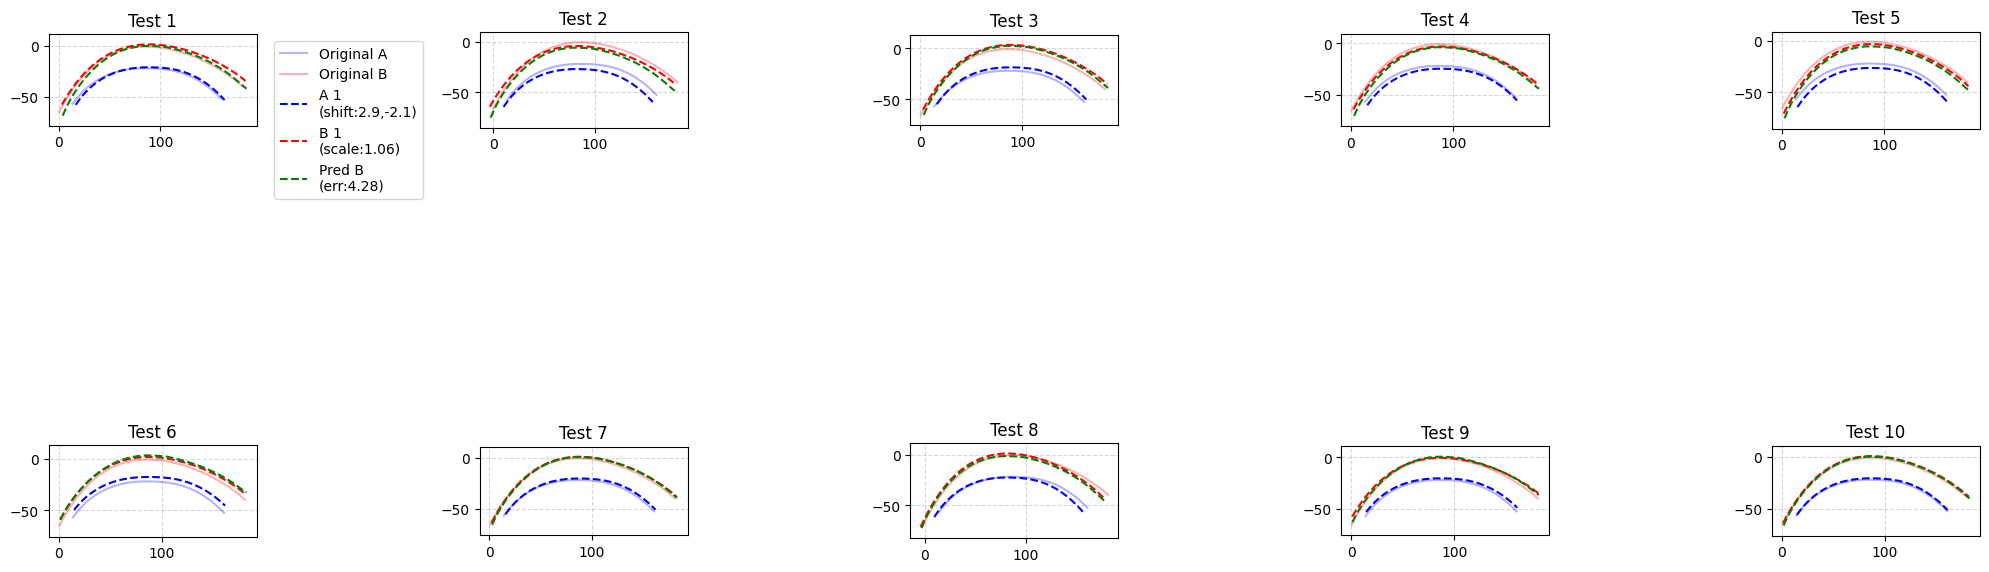


Validation Statistics:
Mean Error: 2.3782 ± 1.1763 pixels
Min Error: 0.8510 pixels
Max Error: 4.3781 pixels


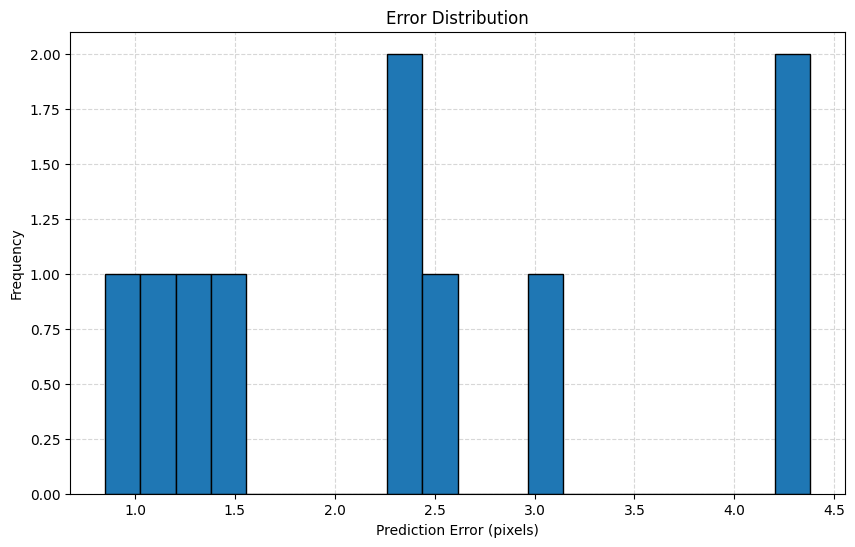

In [38]:
def validate_model_notebook(model, A_points, B_points, X_scaler, y_scaler, n_validations=10):
    """
    Validate model performance with curve transformations
    
    Args:
        model: trained model
        A_points: original A curve points
        B_points: original B curve points
        X_scaler: input data scaler
        y_scaler: output data scaler
        n_validations: number of validation tests
    """
    plt.figure(figsize=(20, 10))
    errors = []
    
    for i in range(n_validations):
        # Translation parameters
        shift_x = np.random.normal(0, 2.0)
        shift_y = np.random.normal(0, 2.0)
        
        # Curve scale parameters
        curve_scale_A = np.random.normal(1.0, 0.1)
        curve_scale_B = np.random.normal(1.0, 0.1)
        
        # Transform A curve
        A_curve = A_points.copy()
        # Ensure continuity of end points
        if np.linalg.norm(A_curve[-1] - A_curve[-2]) < 1e-6:
            direction = A_curve[-1] - A_curve[-2]
            direction = direction / np.linalg.norm(direction)
            A_curve[-1] = A_curve[-2] + direction * 0.1
        
        A_curve[:, 0] += shift_x
        A_curve[:, 1] = A_points[:, 1] * curve_scale_A + shift_y
        
        # Transform B curve
        B_curve = B_points.copy()
        # Ensure continuity of end points
        if np.linalg.norm(B_curve[-1] - B_curve[-2]) < 1e-6:
            direction = B_curve[-1] - B_curve[-2]
            direction = direction / np.linalg.norm(direction)
            B_curve[-1] = B_curve[-2] + direction * 0.1
        
        B_curve[:, 0] += shift_x
        B_curve[:, 1] = B_points[:, 1] * curve_scale_B + shift_y
        
        # Predict B curve
        predicted_B = predict_B_curve(model, A_curve, X_scaler, y_scaler)
        
        # Calculate error
        error = np.mean(np.sqrt(np.sum((predicted_B - B_curve)**2, axis=1)))
        errors.append(error)
        
        # Plot
        ax = plt.subplot(2, 5, i + 1)
        
        # Plot original curves (semi-transparent)
        plt.plot(A_points[:, 0], -A_points[:, 1], 'b-', alpha=0.3, label='Original A')
        plt.plot(B_points[:, 0], -B_points[:, 1], 'r-', alpha=0.3, label='Original B')
        
        # Plot transformed curves
        plt.plot(A_curve[:, 0], -A_curve[:, 1], 'b--', 
                label=f'A {i+1}\n(shift:{shift_x:.1f},{shift_y:.1f})')
        plt.plot(B_curve[:, 0], -B_curve[:, 1], 'r--', 
                label=f'B {i+1}\n(scale:{curve_scale_A:.2f})')
        plt.plot(predicted_B[:, 0], -predicted_B[:, 1], 'g--', 
                label=f'Pred B\n(err:{error:.2f})')
        
        plt.title(f'Test {i+1}')
        plt.grid(True)
        if i == 0:
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
        ax.set_aspect('equal', adjustable='box')
        
        # Set axis range with margin
        all_points = np.vstack([A_points, B_points, A_curve, B_curve, predicted_B])
        x_min, x_max = all_points[:, 0].min(), all_points[:, 0].max()
        y_min, y_max = -all_points[:, 1].max(), -all_points[:, 1].min()
        
        margin = 10
        ax.set_xlim(x_min - margin, x_max + margin)
        ax.set_ylim(y_min - margin, y_max + margin)
    
    plt.tight_layout()
    plt.show()
    
    # Print validation statistics
    print("\nValidation Statistics:")
    print(f"Mean Error: {np.mean(errors):.4f} ± {np.std(errors):.4f} pixels")
    print(f"Min Error: {np.min(errors):.4f} pixels")
    print(f"Max Error: {np.max(errors):.4f} pixels")
    
    # Plot error distribution
    plt.figure(figsize=(10, 6))
    plt.hist(errors, bins=20, edgecolor='black')
    plt.title('Error Distribution')
    plt.xlabel('Prediction Error (pixels)')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

# Example usage:
validate_model_notebook(model, A_points, B_points, X_scaler, y_scaler)

In [39]:
# Save model
print("Model input shape:", model.input_shape)
model.save('curve_model.keras')

Model input shape: (None, 1)


# TEST CASE

警告：第49个点的切向量接近零
A_params范围: 0.0 1.0
X_scaled范围: -1.6980903763362514 1.8095192092179642
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
预测值范围: -3.1860962 2.2432246
反标准化后范围: -22.069263 24.893602
警告：预测时第49个点的切向量接近零
A_params范围: 0.0 1.0
X_scaled范围: -1.6980903763362514 1.8095192092179642
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
预测值范围: -3.1860962 2.2432246
反标准化后范围: -22.069263 24.893602
警告：预测时第49个点的切向量接近零
A_params范围: 0.0 1.0
X_scaled范围: -1.6980903763362514 1.8095192092179642
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
预测值范围: -3.1860962 2.2432246
反标准化后范围: -22.069263 24.893602
警告：预测时第49个点的切向量接近零
A_params范围: 0.0 1.0
X_scaled范围: -1.6980903763362514 1.8095192092179642
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
预测值范围: -3.1860962 2.2432246
反标准化后范围: -22.069263 24.893602
警告：预测时第49个点的切向量接近零
A_params范围: 0.0 1.0
X_scaled范围: -1.6980903763362514 1.8095192092179642
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
预测值范围: -3.1860962 2.2432246
反标准化后范围: -22.069263 24.893602
警告：预测时第49个点的切向量接近零
A_params范围: 0.0 1.0
X_scaled范围: -1.6980903763362514 1.8

/var/folders/hk/f73ww1jd3l32b8bknry1x7v40000gn/T/ipykernel_20568/3273071520.py:184: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


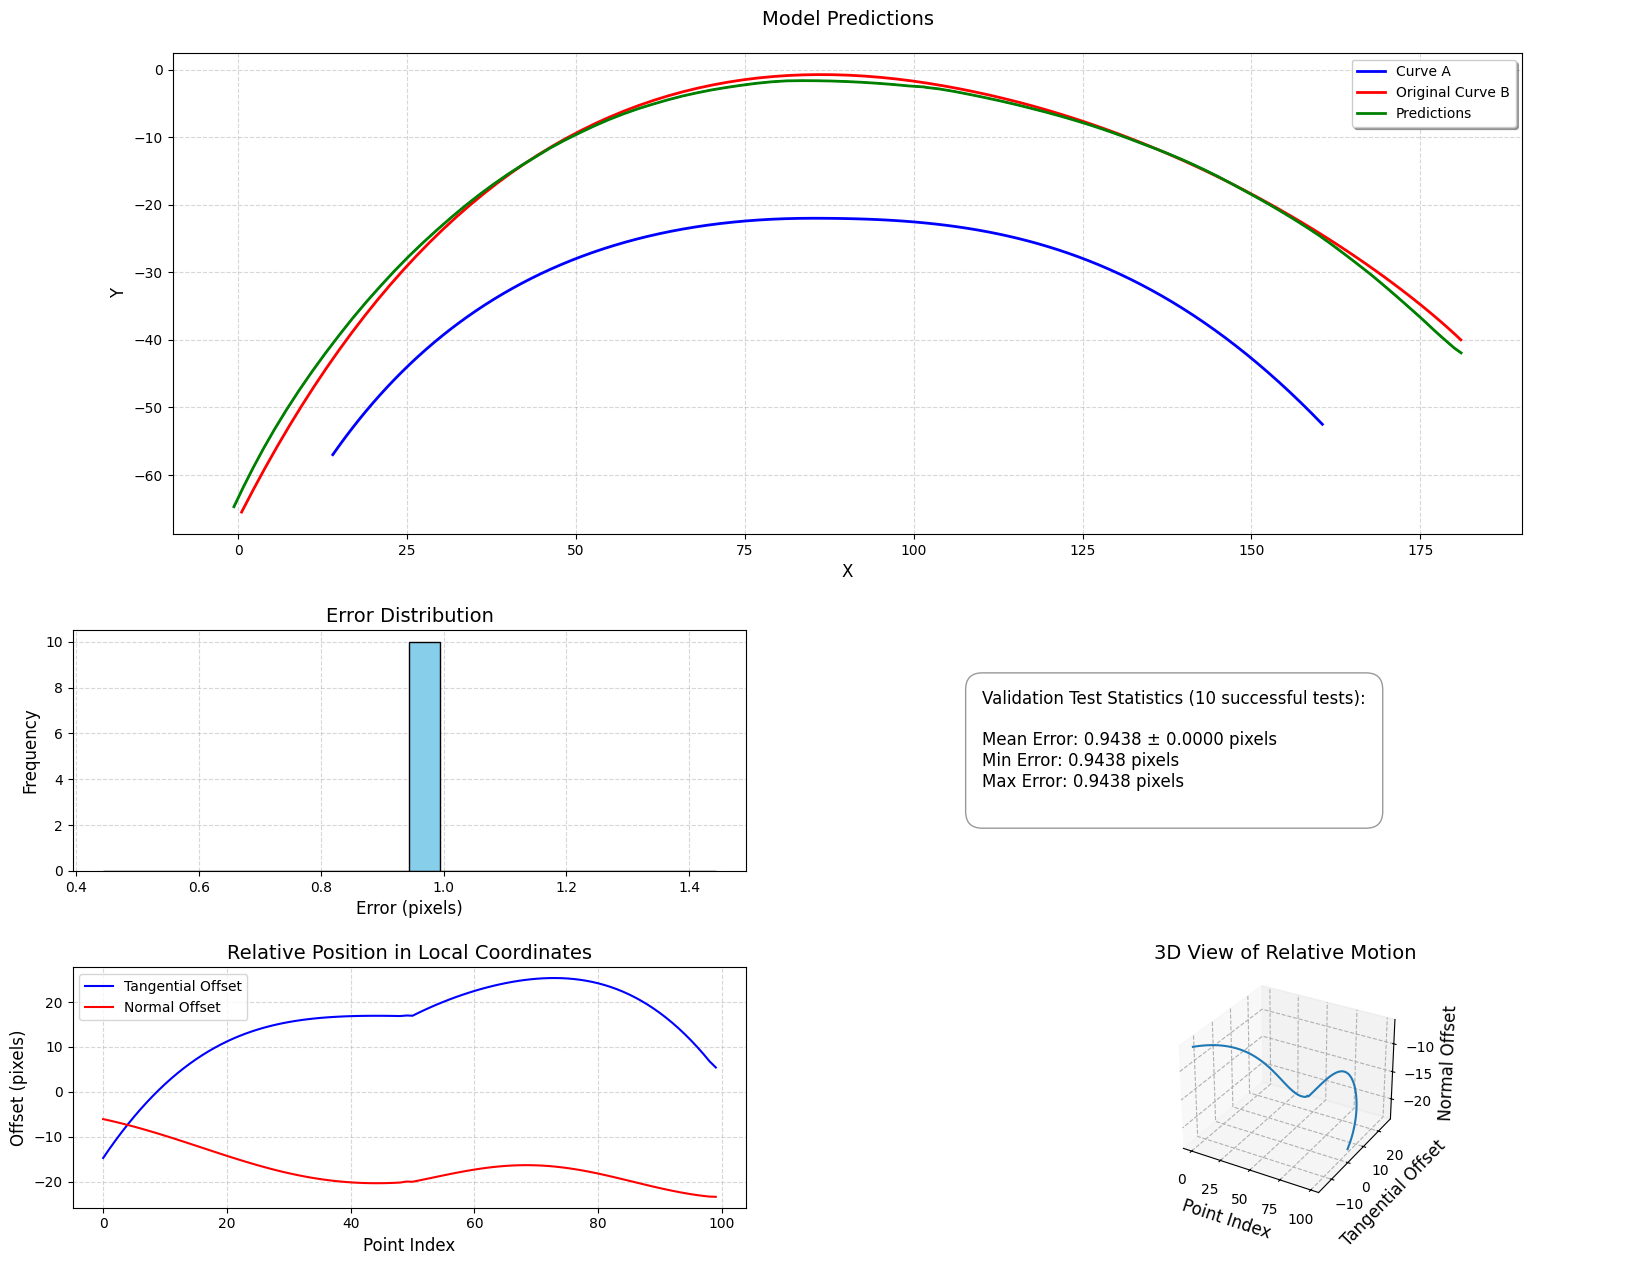

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # 必须导入这个才能使用3D投影
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
import os

try:
    from train_model import predict_B_curve
except ImportError:
    raise ImportError("Could not import predict_B_curve from train_model.py. Make sure the file exists and is in the correct path.")

def load_and_test_model(model_path, A_points, B_points, n_tests=10):
    """
    Load model and perform multiple validation tests with consistent test data
    
    Args:
        model_path: Path to saved model
        A_points: Points of curve A
        B_points: Points of curve B
        n_tests: Number of test iterations
    """
    # Check if model exists
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model file not found at {model_path}")
        
    try:
        # Load model
        model = keras.models.load_model(model_path, compile=False)
        
        # Recompile model
        model.compile(
            optimizer='adam',
            loss=keras.losses.MeanSquaredError(),
            metrics=[keras.metrics.MeanAbsoluteError()]
        )
    except Exception as e:
        raise Exception(f"Error loading model: {str(e)}")
    
    # Validate input shapes
    if len(A_points.shape) != 2 or A_points.shape[1] != 2:
        raise ValueError("A_points must be a 2D array with shape (n_points, 2)")
    if len(B_points.shape) != 2 or B_points.shape[1] != 2:
        raise ValueError("B_points must be a 2D array with shape (n_points, 2)")
    if A_points.shape[0] != B_points.shape[0]:
        raise ValueError("A_points and B_points must have the same number of points")
    
    # Create and fit data scalers
    X_scaler = StandardScaler()
    y_scaler = StandardScaler()
    
    # Calculate curve parameters
    A_diffs = np.diff(A_points, axis=0)
    A_lengths = np.sqrt(np.sum(A_diffs**2, axis=1))
    curve_length = np.sum(A_lengths)
    
    # Prepare data for standardization
    A_cumsum = np.cumsum(A_lengths)
    A_cumsum = np.insert(A_cumsum, 0, 0)
    A_params = A_cumsum / A_cumsum[-1]
    
    # Calculate B curve offsets relative to A curve
    offsets = []
    for i in range(len(A_points)):
        if i == len(A_points) - 1:
            tangent = A_points[i] - A_points[i-1]
        else:
            tangent = A_points[i+1] - A_points[i]
            
        tangent_norm = np.linalg.norm(tangent)
        if tangent_norm < 1e-10:
            print(f"警告：第{i}个点的切向量接近零")
            tangent = np.array([1e-10, 0])
            tangent_norm = np.linalg.norm(tangent)
            
        tangent = tangent / tangent_norm
        normal = np.array([-tangent[1], tangent[0]])
        diff = B_points[i] - A_points[i]
        
        tangential_offset = np.dot(diff, tangent)
        normal_offset = np.dot(diff, normal)
        offsets.append([tangential_offset, normal_offset])
    
    offsets = np.array(offsets)
    
    # Fit scalers
    X_scaler.fit(A_params.reshape(-1, 1))
    y_scaler.fit(offsets)
    
    try:
        # Create subplot layout
        fig = plt.figure(figsize=(20, 15))
        gs = plt.GridSpec(3, 2, height_ratios=[2, 1, 1], hspace=0.3, wspace=0.3)
        
        # Set default style parameters
        plt.rcParams['grid.linestyle'] = '--'
        plt.rcParams['grid.alpha'] = 0.5
        plt.rcParams['axes.grid'] = True
        plt.rcParams['axes.axisbelow'] = True
        
        # Curve comparison plot
        ax1 = fig.add_subplot(gs[0, :])
        ax1.plot(A_points[:, 0], -A_points[:, 1], 'b-', label='Curve A', linewidth=2)
        ax1.plot(B_points[:, 0], -B_points[:, 1], 'r-', label='Original Curve B', linewidth=2)
        ax1.grid(True, which='both', linestyle='--', alpha=0.5)
        
        # Perform validation tests
        errors = []
        predicted_curves = []
        for i in range(n_tests):
            try:
                # Use consistent test data from notebook
                predicted_B = predict_B_curve(model, A_points, X_scaler, y_scaler)
                predicted_curves.append(predicted_B)
                
                # Calculate error
                error = np.mean(np.sqrt(np.sum((predicted_B - B_points)**2, axis=1)))
                errors.append(error)
                
                # Plot predicted curve
                ax1.plot(predicted_B[:, 0], -predicted_B[:, 1], 'g-', alpha=0.3, linewidth=1)
            except Exception as e:
                print(f"Warning: Error in test iteration {i}: {str(e)}")
                continue
        
        if not errors:
            raise Exception("All test iterations failed")
            
        # Show last prediction in darker color
        ax1.plot(predicted_B[:, 0], -predicted_B[:, 1], 'g-', label='Predictions', linewidth=2)
        ax1.legend(loc='upper right', frameon=True, 
                  bbox_to_anchor=(1.0, 1.0),
                  fancybox=True, shadow=True)
        ax1.set_title('Model Predictions', pad=20, fontsize=14)
        ax1.set_xlabel('X', fontsize=12)
        ax1.set_ylabel('Y', fontsize=12)
        ax1.set_aspect('equal')
        
        # Error distribution histogram
        ax2 = fig.add_subplot(gs[1, 0])
        ax2.hist(errors, bins=20, color='skyblue', edgecolor='black')
        ax2.set_title('Error Distribution', fontsize=14)
        ax2.set_xlabel('Error (pixels)', fontsize=12)
        ax2.set_ylabel('Frequency', fontsize=12)
        ax2.grid(True, which='both', linestyle='--', alpha=0.5)
        
        # Error statistics
        ax3 = fig.add_subplot(gs[1, 1])
        ax3.axis('off')
        stats_text = f"Validation Test Statistics ({len(errors)} successful tests):\n\n"
        stats_text += f"Mean Error: {np.mean(errors):.4f} ± {np.std(errors):.4f} pixels\n"
        stats_text += f"Min Error: {np.min(errors):.4f} pixels\n"
        stats_text += f"Max Error: {np.max(errors):.4f} pixels\n"
        
        # Add text with nice box
        ax3.text(0.05, 0.5, stats_text,
                 fontsize=12,
                 verticalalignment='center',
                 bbox=dict(
                     boxstyle='round,pad=1',
                     facecolor='white',
                     edgecolor='gray',
                     alpha=0.8
                 ))
        
        # Add relative position plots
        ax4 = fig.add_subplot(gs[2, 0])
        ax4.plot(np.arange(len(offsets)), offsets[:, 0], 'b-', label='Tangential Offset')
        ax4.plot(np.arange(len(offsets)), offsets[:, 1], 'r-', label='Normal Offset')
        ax4.set_title('Relative Position in Local Coordinates', fontsize=14)
        ax4.set_xlabel('Point Index', fontsize=12)
        ax4.set_ylabel('Offset (pixels)', fontsize=12)
        ax4.grid(True)
        ax4.legend()
        
        # 3D view of relative motion
        ax5 = fig.add_subplot(gs[2, 1], projection='3d')
        ax5.plot(np.arange(len(offsets)), offsets[:, 0], offsets[:, 1])
        ax5.set_title('3D View of Relative Motion', fontsize=14)
        ax5.set_xlabel('Point Index', fontsize=12)
        ax5.set_ylabel('Tangential Offset', fontsize=12)
        ax5.set_zlabel('Normal Offset', fontsize=12)
        
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Error in visualization: {str(e)}")
        raise
    
    return model, X_scaler, y_scaler

# 示例用法
if __name__ == "__main__":
    try:
        from svg.path import parse_path
        from svg.path.path import Line, CubicBezier
    except ImportError:
        raise ImportError("Could not import svg.path. Please install it with: pip install svg.path")
    
    # 输入曲线数据
    A_d = "M14 57.0001C29.3464 35.0113 51.5 22 85 22C110 22 134 25 160.5 52.5"
    B_d = "M0.5 65.5C28.9136 9.86327 64 -3.92666 102 1.99999C140 7.92664 170 29.5 181 40"
    
    def parse_svg_path(d):
        path = parse_path(d)
        segments = []
        for e in path:
            if isinstance(e, CubicBezier):
                segments.append({
                    'start': (e.start.real, e.start.imag),
                    'c1': (e.control1.real, e.control1.imag),
                    'c2': (e.control2.real, e.control2.imag),
                    'end': (e.end.real, e.end.imag)
                })
            elif isinstance(e, Line):
                segments.append({
                    'start': (e.start.real, e.start.imag),
                    'end': (e.end.real, e.end.imag)
                })
        return segments

    def bezier_sample(segments, n_samples=50):
        points = []
        for seg in segments:
            if 'c1' in seg:  # 三次贝塞尔曲线
                t = np.linspace(0, 1, n_samples)
                x = (1-t)**3*seg['start'][0] + 3*(1-t)**2*t*seg['c1'][0] + 3*(1-t)*t**2*seg['c2'][0] + t**3*seg['end'][0]
                y = (1-t)**3*seg['start'][1] + 3*(1-t)**2*t*seg['c1'][1] + 3*(1-t)*t**2*seg['c2'][1] + t**3*seg['end'][1]
                points.extend(list(zip(x, y)))
            else:  # 直线段
                x = np.linspace(seg['start'][0], seg['end'][0], n_samples)
                y = np.linspace(seg['start'][1], seg['end'][1], n_samples)
                points.extend(list(zip(x, y)))
        return np.array(points)

    try:
        # 解析和采样曲线
        A_segments = parse_svg_path(A_d)
        B_segments = parse_svg_path(B_d)
        A_points = bezier_sample(A_segments)
        B_points = bezier_sample(B_segments)
        
        # 加载并测试模型
        model_path = 'curve_model.keras'  # 模型保存路径
        load_and_test_model(model_path, A_points, B_points, n_tests=10)
    except Exception as e:
        print(f"Error in main: {str(e)}")
        raise


A_params范围: 0.0 1.0
X_scaled范围: -1.6973317055007067 1.8090857284883435
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
预测值范围: -3.1827378 2.2415183
反标准化后范围: -23.440575 25.305271
警告：预测时第49个点的切向量接近零
A_params范围: 0.0 1.0
X_scaled范围: -1.6973317055007067 1.8090857284883435
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
预测值范围: -3.1827378 2.2415183
反标准化后范围: -23.440575 25.305042
警告：预测时第49个点的切向量接近零
A_params范围: 0.0 1.0
X_scaled范围: -1.6973317055007067 1.8090857284883435
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
预测值范围: -3.1827378 2.2415183
反标准化后范围: -23.440575 25.305822
警告：预测时第49个点的切向量接近零


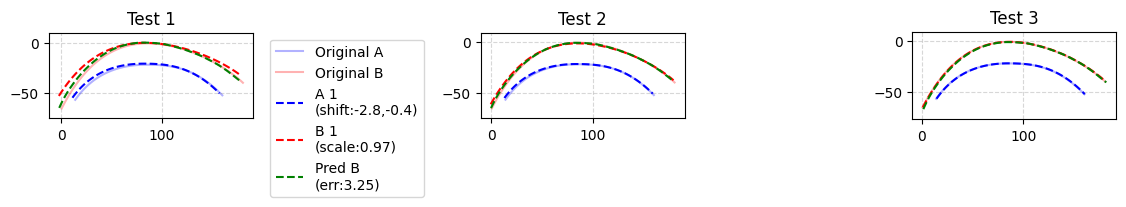

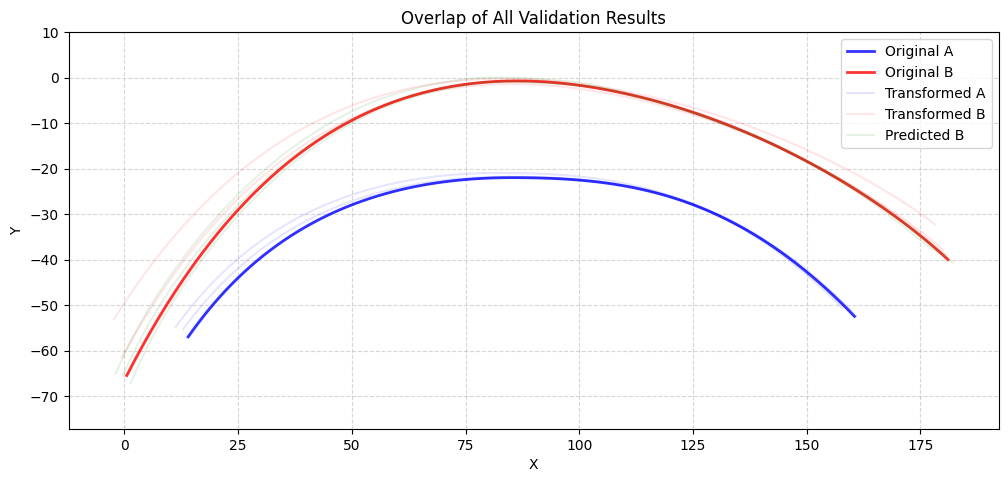

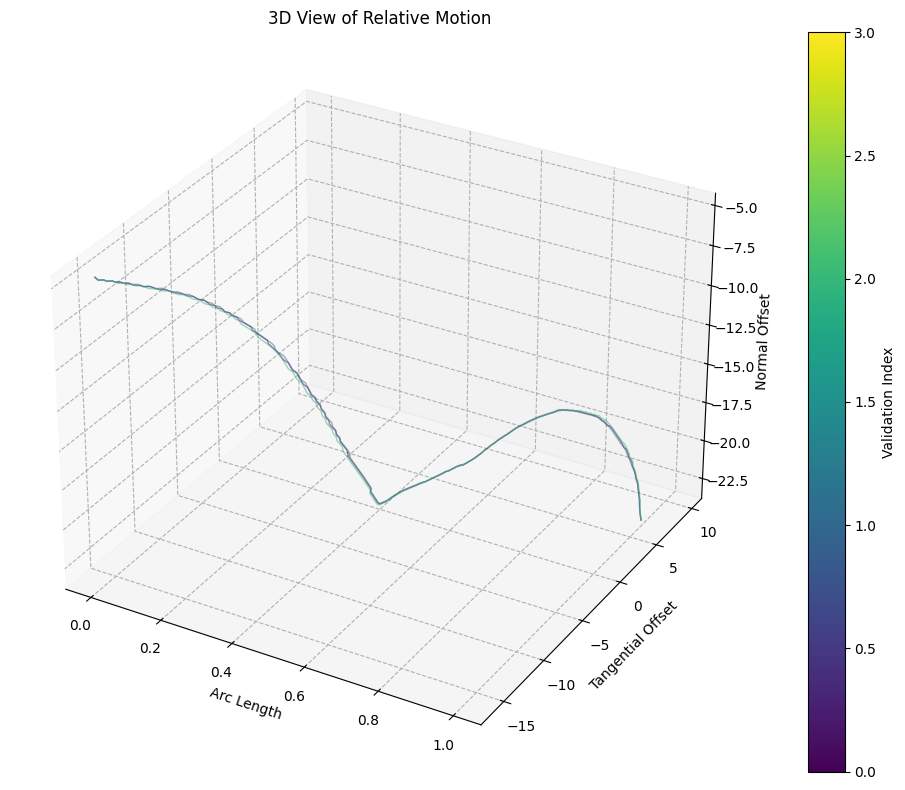


Validation Statistics:
Mean Error: 1.6708 ± 1.1180 pixels
Min Error: 0.7587 pixels
Max Error: 3.2453 pixels


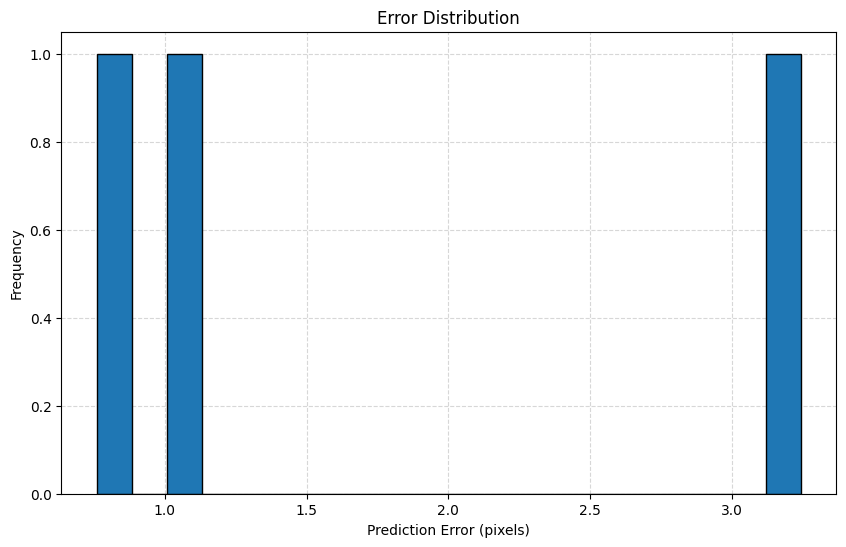

In [51]:
def arc_length_parameterization(points):
    """Arc length parameterization"""
    dx = np.diff(points[:,0])
    dy = np.diff(points[:,1])
    seg_lengths = np.sqrt(dx**2 + dy**2)
    cum_length = np.cumsum(seg_lengths)
    total_length = cum_length[-1]
    normalized = np.insert(cum_length, 0, 0) / total_length
    return normalized, total_length

def compute_tangent_normal(points):
    """Compute curve tangent and normal vectors"""
    dx = np.gradient(points[:,0])
    dy = np.gradient(points[:,1])
    
    lengths = np.sqrt(dx**2 + dy**2)
    tangent = np.column_stack([dx/lengths, dy/lengths])
    normal = np.column_stack([-tangent[:,1], tangent[:,0]])
    
    return tangent, normal

def transform_to_local_coordinates(point, origin, tangent, normal):
    """Transform point to local coordinate system"""
    translated = point - origin
    x_local = np.dot(translated, tangent)
    y_local = np.dot(translated, normal)
    return np.array([x_local, y_local])

def validate_model_multiple_times(model_path, A_points, B_points, X_scaler, y_scaler, n_validations=100):
    """
    Validate model multiple times with random transformations
    
    Args:
        model_path: Path to model file
        A_points: Points of curve A
        B_points: Points of curve B
        X_scaler: Input data scaler
        y_scaler: Output data scaler
        n_validations: Number of validations
    """
    # Load model
    model = keras.models.load_model(model_path, compile=False)
    model.compile(
        optimizer='adam',
        loss='mse',
        metrics=['mae']
    )
    
    # Create figure for individual plots
    plt.figure(figsize=(20, 10))
    errors = []
    
    # Store all curves for overlap plot
    all_A_curves = []
    all_B_curves = []
    all_pred_B = []
    
    for i in range(n_validations):
        # Translation parameters
        shift_x = np.random.normal(0, 2.0)
        shift_y = np.random.normal(0, 2.0)
        
        # Scaling parameters
        curve_scale_A = np.random.normal(1.0, 0.1)
        curve_scale_B = np.random.normal(1.0, 0.1)
        
        # Transform curve A
        A_curve = A_points.copy()
        if np.linalg.norm(A_curve[-1] - A_curve[-2]) < 1e-6:
            direction = A_curve[-1] - A_curve[-2]
            direction = direction / np.linalg.norm(direction)
            A_curve[-1] = A_curve[-2] + direction * 0.1
        
        A_curve[:, 0] += shift_x
        A_curve[:, 1] = A_points[:, 1] * curve_scale_A + shift_y
        
        # Transform curve B
        B_curve = B_points.copy()
        if np.linalg.norm(B_curve[-1] - B_curve[-2]) < 1e-6:
            direction = B_curve[-1] - B_curve[-2]
            direction = direction / np.linalg.norm(direction)
            B_curve[-1] = B_curve[-2] + direction * 0.1
        
        B_curve[:, 0] += shift_x
        B_curve[:, 1] = B_points[:, 1] * curve_scale_B + shift_y
        
        # Predict curve B
        predicted_B = predict_B_curve(model, A_curve, X_scaler, y_scaler)
        
        # Store curves for overlap plot
        all_A_curves.append(A_curve)
        all_B_curves.append(B_curve)
        all_pred_B.append(predicted_B)
        
        # Calculate error
        error = np.mean(np.sqrt(np.sum((predicted_B - B_curve)**2, axis=1)))
        errors.append(error)
        
        # Draw individual plots
        if i < 10:
            ax = plt.subplot(2, 5, i + 1)
            
            plt.plot(A_points[:, 0], -A_points[:, 1], 'b-', alpha=0.3, label='Original A')
            plt.plot(B_points[:, 0], -B_points[:, 1], 'r-', alpha=0.3, label='Original B')
            
            plt.plot(A_curve[:, 0], -A_curve[:, 1], 'b--', 
                    label=f'A {i+1}\n(shift:{shift_x:.1f},{shift_y:.1f})')
            plt.plot(B_curve[:, 0], -B_curve[:, 1], 'r--', 
                    label=f'B {i+1}\n(scale:{curve_scale_A:.2f})')
            plt.plot(predicted_B[:, 0], -predicted_B[:, 1], 'g--', 
                    label=f'Pred B\n(err:{error:.2f})')
            
            plt.title(f'Test {i+1}')
            plt.grid(True)
            if i == 0:
                plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            
            ax.set_aspect('equal', adjustable='box')
            
            all_points = np.vstack([A_points, B_points, A_curve, B_curve, predicted_B])
            x_min, x_max = all_points[:, 0].min(), all_points[:, 0].max()
            y_min, y_max = -all_points[:, 1].max(), -all_points[:, 1].min()
            
            margin = 10
            ax.set_xlim(x_min - margin, x_max + margin)
            ax.set_ylim(y_min - margin, y_max + margin)
        
        if (i + 1) % 10 == 0:
            print(f"Completed {i + 1}/{n_validations} validations")
    
    plt.tight_layout()
    plt.show()
    
    # Create overlap plot
    plt.figure(figsize=(12, 8))
    
    # Plot original curves
    plt.plot(A_points[:, 0], -A_points[:, 1], 'b-', linewidth=2, label='Original A', alpha=0.8)
    plt.plot(B_points[:, 0], -B_points[:, 1], 'r-', linewidth=2, label='Original B', alpha=0.8)
    
    # Plot all transformed and predicted curves
    for i in range(n_validations):
        plt.plot(all_A_curves[i][:, 0], -all_A_curves[i][:, 1], 'b-', alpha=0.1)
        plt.plot(all_B_curves[i][:, 0], -all_B_curves[i][:, 1], 'r-', alpha=0.1)
        plt.plot(all_pred_B[i][:, 0], -all_pred_B[i][:, 1], 'g-', alpha=0.1)
    
    plt.title('Overlap of All Validation Results')
    plt.grid(True)
    plt.legend(['Original A', 'Original B', 'Transformed A', 'Transformed B', 'Predicted B'])
    
    ax = plt.gca()
    ax.set_aspect('equal', adjustable='box')
    
    all_points = np.vstack([
        A_points, B_points,
        *all_A_curves, *all_B_curves, *all_pred_B
    ])
    x_min, x_max = all_points[:, 0].min(), all_points[:, 0].max()
    y_min, y_max = -all_points[:, 1].max(), -all_points[:, 1].min()
    
    margin = 10
    plt.xlim(x_min - margin, x_max + margin)
    plt.ylim(y_min - margin, y_max + margin)
    
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()
    
    ###

        # Create 3D visualization of relative motion using arc length parameterization
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    def process_curves(curve_A, curve_B):
        # Arc length parameterization
        s_A, _ = arc_length_parameterization(curve_A)
        tangent_A, normal_A = compute_tangent_normal(curve_A)
        
        # Create dense sampling of curve B
        num_samples = 1000
        t_dense = np.linspace(0, 1, num_samples)
        B_dense = np.column_stack([
            np.interp(t_dense, np.linspace(0, 1, len(curve_B)), curve_B[:,0]),
            np.interp(t_dense, np.linspace(0, 1, len(curve_B)), curve_B[:,1])
        ])
        
        # Arc length parameterization for dense B curve
        s_B_dense, _ = arc_length_parameterization(B_dense)
        
        # Sample points on curve A
        num_A_samples = 200
        s_values = np.linspace(0, 1, num_A_samples)
        A_sampled = np.column_stack([
            np.interp(s_values, np.linspace(0, 1, len(curve_A)), curve_A[:,0]),
            np.interp(s_values, np.linspace(0, 1, len(curve_A)), curve_A[:,1])
        ])
        
        # Compute tangent and normal vectors for sampled points
        tangent_sampled, normal_sampled = compute_tangent_normal(A_sampled)
        
        # Calculate local coordinates
        local_coordinates = []
        for i in range(len(s_values)):
            idx = np.argmin(np.abs(s_B_dense - s_values[i]))
            B_point = B_dense[idx]
            
            local_coord = transform_to_local_coordinates(
                B_point,
                A_sampled[i],
                tangent_sampled[i],
                normal_sampled[i]
            )
            local_coordinates.append(local_coord)
            
        return s_values, np.array(local_coordinates)
    
    # Process and plot each validation result
    for i in range(n_validations):
        s_values, local_coords = process_curves(all_A_curves[i], all_pred_B[i])
        
        # Plot exactly like the original example
        ax.plot(s_values, local_coords[:,0], local_coords[:,1],
                alpha=0.5, linewidth=1,
                color=plt.cm.viridis(i/n_validations))
    
    # Set labels exactly as in the original
    ax.set_xlabel('Arc Length')
    ax.set_ylabel('Tangential Offset')
    ax.set_zlabel('Normal Offset')
    ax.set_title('3D View of Relative Motion')
    
    # Add colorbar
    norm = plt.Normalize(0, n_validations)
    sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, ax=ax, label='Validation Index')
    
    plt.tight_layout()
    plt.show()
    
    # Print validation statistics
    print("\nValidation Statistics:")
    print(f"Mean Error: {np.mean(errors):.4f} ± {np.std(errors):.4f} pixels")
    print(f"Min Error: {np.min(errors):.4f} pixels")
    print(f"Max Error: {np.max(errors):.4f} pixels")
    
    # Plot error distribution
    plt.figure(figsize=(10, 6))
    plt.hist(errors, bins=20, edgecolor='black')
    plt.title('Error Distribution')
    plt.xlabel('Prediction Error (pixels)')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()
    
    return errors

# Example usage
errors = validate_model_multiple_times(
    'curve_model.keras', 
    A_points, 
    B_points, 
    X_scaler, 
    y_scaler, 
    n_validations=3
)